# Tutorial: Métricas de Performance para Modelos de Classificação

### Introdução: Machine Learning na prática

Em uma ***aplicação real de um algoritmo de Machine Learning***, é uma boa prática escolher previamente uma ***métrica de performance a ser otimizada***. Após uma primeira versão do algoritmo, são feitas novas versões em um processo iterativo de melhoria da performance. Escolher a ***métrica de performance adequada*** é uma das primeiras questões que um engenheiro de Machine Learning irá encontrar em uma aplicação real.

### Performance de um modelo de probabilidade de falha de equipamentos

Considere a situação real de uma indústria que possui uma série de ***equipamentos em operação***. 
Notando que há uma significativa economia de recursos quando é feita a ***manutenção preventiva***, ou seja, se antecipa uma falha e previne-se a ocorrência da mesma, você propõe um ***modelo de Deep Learning que faz a previsão da probabilidade de falha, a partir dos dados de telemetria.***

Os engenheiros gostaram da sua idéia mas estão céticos.

No código a seguir você calcula a ***Acurácia*** do modelo (taxa de acerto) para convencê-los da qualidade do trabalho.

O código a seguir carrega as bibliotecas que iremos utilizar em Python, os dados que serão utilizados para validação e também um modelo de Deep Learning pré-treinado em um conjunto de dados de treino.

In [1]:
# Carrega as bibliotecas necessárias para o desenvolvimento

# dataset manipulation and visualization
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from seaborn import regplot
sns.set_style("whitegrid")

# modelling and diagnostics
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score,\
precision_recall_curve, confusion_matrix
from tensorflow.keras.models import load_model

In [2]:
# conjunto de dados de validação

# X = dados de telemetria
with open('X_val.pickle', 'rb') as handle:
    X_val = pickle.load(handle)

# Y = indicador de falha
with open('Y_val.pickle', 'rb') as handle:
    Y_val = pickle.load(handle)

# modelo compilado pré treinado
model = load_model('my_model.h5')

Abaixo, verifica-se o formato dos arrays do conjunto de dados de validação, no qual iremos calcular a performance.

- ***X_val: 278 exemplos de treinamento, 10 eventos temporais, e 10 campos de telemeria.***
- ***Y_val: 270 exemplos de treinamento, 10 eventos temporais, indicador de falha.***

In [3]:
# exibo o formato dos dados
print(X_val.shape)
print(Y_val.shape)

(278, 10, 10)
(278, 10, 1)


Com os dados carregados e o modelo também, podemos calcular a Acurácia para o conjunto de validação:

In [4]:
# mudo o formato dos arrays para uma única linha
Y_val_line = np.reshape(Y_val, (-1))

# obtenho a previsão do modelo de probabilidade
Y_pred_line =  np.reshape(model.predict_classes(X_val), (-1))

# calculo acurácia
val_acc = model.evaluate(
        X_val, Y_val, verbose=False)[1]
print('')
print('Acurácia de validação: %.3f'%val_acc)

# confusion matrix
cf_matrix_validation = confusion_matrix(Y_val_line,Y_pred_line)


Acurácia de validação: 0.994


Após calcular a acurácia do modelo e enviar para a equipe de engenharia, você recebe a seguinte resposta:

*** Como eu podemos saber a economia dos custos de manutenção a partir desta métrica que nos enviou? ***

Dica: Para calcular a redução de custos, você precisa considerar os ***Falsos Positivos*** e ***Falsos Negativos***. Portanto, determinar a Acurácia somente, não ajuda muito no convencimento da equipe de engenharia. 

A presença de falsos positivos gera custo adicional de manutenção, e a presença de falsos negativos geraria custos ligados a falha não detectada.

Para se ter uma idéia melhor do que está acontecendo no modelo é sempre válido olhar a matriz de confusão:

- linhas : valor verdadeiro
- colunas : predição

In [5]:
# confusion matrix
cf_matrix_validation = confusion_matrix(Y_val_line,Y_pred_line)

print(cf_matrix_validation)

[[2755    6]
 [  11    8]]


Uma outra forma de ver que o resultado de 99,4% de acurácia não é informativo é calcular o % de falhas de equipamentos no conjunto de dados:

In [6]:
# % de falhas de equipamentos
print("%.3f"%(np.sum(Y_val)/Y_val.size))

0.007


Com o percentual de 0,07% de falhas, um modelo constante Y_val = 0, teria acurácia de 99,3%, e seria completamente inútil.

### Precision, Recall
Uma forma de capturar os efeitos dos ***Falsos Positivos e Falsos Negativos, bem como os casos em que há acerto*** na detecão da falha é utilizar seguintes métricas:

***Precision: # de falhas detectadas / # falhas apontadas pelo modelo***

***Recall: # de falhas detectadas / # falhas totais***

![fonte: Wikipedia](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)
fonte: Wikipedia https://en.wikipedia.org/wiki/Precision_and_recall

In [7]:
# performance
print("Precision para o dataset de validação: %.2f"
      %precision_score(Y_val_line,Y_pred_line))

# performance
print("Recall para o dataset de validação: %.2f"
      %recall_score(Y_val_line,Y_pred_line))

Precision para o dataset de validação: 0.57
Recall para o dataset de validação: 0.42


Acima, quando calculamos a previsão do modelo, implicitamente, verificamos se a probabilidade de falha era maior do que 50% (p > 0.5). 

Conforme vamos aumentando a probabilidade de corte [0.4, 0.5, 0.6 ...] , a precisão do modelo tende a ser maior e menor a quantidade de eventos de falha são capturados, portanto menor o Recall.

Fica claro então, que há um trade off entre Precision e Recall. Este trade off pode ser verificado para nosso conjunto de dados através da curva Precision x Recall abaixo:

In [8]:
# probabilidade de falha
Y_prob_line =  np.reshape(model.predict_proba(X_val), (-1))

# curva de precision recall
pr_curve = precision_recall_curve(Y_val_line,Y_prob_line)

/home/nocedan/cshg-pyenv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


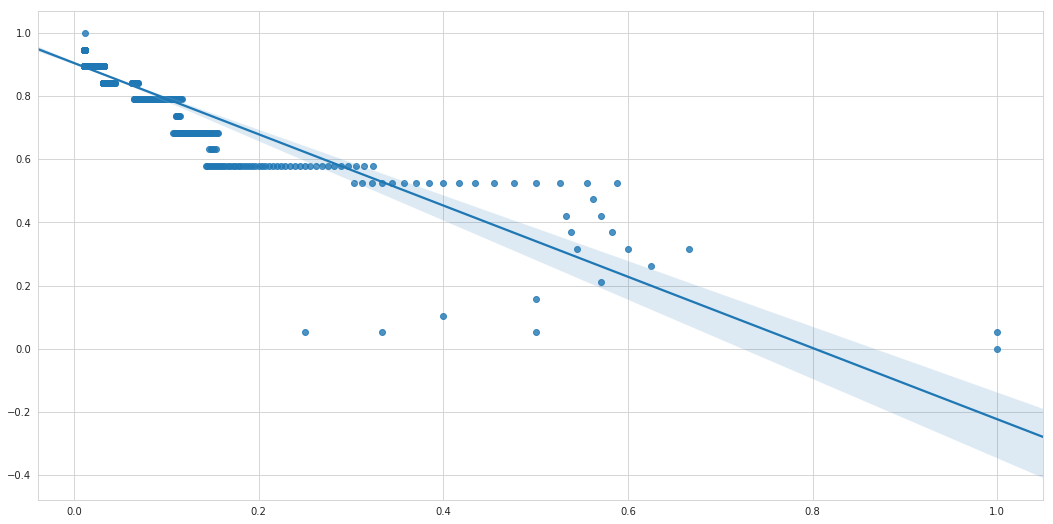

In [9]:
# Verifica o trade off para entre as taxas para diferentes pontos de corte
fig, ax = plt.subplots(figsize=(18,9))
ax = regplot(x = pr_curve[0], y = pr_curve[1], ax=ax)
plt.show()

### F1-Score

Os engenheiros ficam satisfeitos porque conseguem relacionar a metrica de performance com a redução de custo de manutenção. 

Quando você conta isso à sua equipe, eles ficam felizes, mas há um problema. Durante o processo de modelagem, há muitas iterações do algoritmo. Quando estamos lidando com duas ou três métricas, Precision, Recall e Accuracy, pode ser difícil de avaliar rapidamente se houve uma melhoria no algoritmo de uma iteração para outra. 

Como saída para este dilema, você propõe a utilização do F1-Score. Que funciona como uma espécie de média entre Precision e Recall:

\begin{align}
F = 2*\frac{Precision*Recall}{Precision + Recall}
\end{align}

In [10]:
# F1-score
print("F1-Score f para o dataset de validação: %.2f"
      %f1_score(Y_val_line,Y_pred_line))

F1-Score f para o dataset de validação: 0.48


Como esperado, o F1-Score está no intervalo entre o valor de precision e recall, que é [.57, .42]